In [3]:
import camelot
import pandas as pd
import matplotlib.pyplot as plt

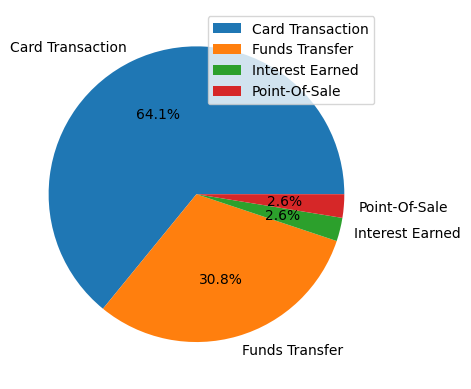

2548.2400000000002
2498.0600000000004


,Date,Code,Type,Reference,Debit,Credit
0,21 Feb 2023,MST,Card Transaction,Debit Card Transaction GOJEK 90 10 19FEB 4628-...,S$19.00,
1,21 Feb 2023,MST,Card Transaction,Debit Card Transaction GRAB SI NG 18FEB 4628-4...,S$19.10,
2,19 Feb 2023,MST,Card Transaction,Debit Card Transaction AUNTIE ANNE'S-PAYA LEB ...,S$7.20,
3,19 Feb 2023,MST,Card Transaction,Debit Card Transaction ORDER.PLAC* TONKOTSUKI ...,S$4.65,
4,19 Feb 2023,MST,Card Transaction,Debit Card Transaction ORDER.PLAC* TONKOTSUKI ...,S$43.60,
...,...,...,...,...,...,...
112,30 Nov 2022,MST,Card Transaction,Debit Card Transaction GENKI SUSHI-SPC SI NG 2...,S$43.20,
113,29 Nov 2022,MST,Card Transaction,Debit Card Transaction GOJEK 90 10 27NOV 4628-...,S$28.70,
114,29 Nov 2022,MST,Card Transaction,Debit Card Transaction GOJEK 90 10 26NOV 4628-...,S$19.40,
115,29 Nov 2022,MST,Card Transaction,Debit Card Transaction MCDONALD'S (PLSQ) SI NG...,S$21.75,


In [9]:
def parseData(file):
    ## parse pdf to extract table data
    tables = camelot.read_pdf(file, flavor='stream', pages='all')

    ## create concat df
    concat = tables[0].df.copy()

    ## concatenate all tables into one
    for i in range(1, len(tables)):
        concat = pd.concat([concat, tables[i].df])


    ## filter out nonsensical data
    concat = concat[~concat.apply(lambda row: row.astype(str).str.contains('about:blank')).any(axis=1)]

    ## reset index of df
    concat = concat.reset_index(drop=True)

    if concat.shape[-1] == 7:
        concat = concat.drop(concat.columns[-1], axis=1)

    ## rename columns
    concat.columns = ['Date', 'Code', 'Reference', 'Debit', 'Credit', 'Extra']

    ## handle bad formatting
    for row in range(len(concat)):
        value = concat.at[row, 'Credit']
        extraVal = concat.at[row, 'Extra']
        
        if value != '':
            concat.at[row, 'Debit'] = value
            concat.at[row, 'Credit'] = ''
        
        if extraVal != '':
            concat.at[row, 'Credit'] = extraVal
            concat.at[row, 'Extra'] = ''
            
    ## drop useless column
    concat = concat.drop(columns=['Extra'])

    firstCell = concat.at[0, 'Date']
    secondCell = concat.at[1, 'Debit']
    thirdCell = concat.at[2, 'Debit']
    fourthCell = concat.at[3, 'Debit']

    if firstCell.split(' ')[0] == 'Transaction':
        concat = concat.drop([0])
        
    if secondCell == 'Download':
        concat = concat.drop([1])
        
    if thirdCell == 'Debit':
        concat = concat.drop([2])
        
    if fourthCell == '(Withdrawal)':
        concat = concat.drop([3])
        
    concat = concat.reset_index(drop=True)

    concat['Type'] = ''
    concat = concat.reindex(columns=['Date', 'Code', 'Type', 'Reference', 'Debit', 'Credit'])


    for a in range(len(concat)):
        code = concat.at[a, 'Code']
        steps = 0
        
        if code != '':
            addArr = []
            index = a + 1
            
            while True:
                if index > len(concat)-1:
                    break
                    
                check = concat.at[index, 'Code']
                if check == '':
                    addArr.append(concat.at[index, 'Reference'])
                    steps += 1
                    index += 1
                else:
                    break
                
            for step in range(steps):
                if concat.at[a, 'Reference'][-1] == '-' or concat.at[a, 'Reference'][-1].isdigit() == True:
                    concat.at[a, 'Reference'] += concat.at[a+step+1, 'Reference']
                else:
                    concat.at[a, 'Reference'] += ' ' + concat.at[a+step+1, 'Reference']
                    
                concat.at[a+step+1, 'Reference'] = ''

            
    ## remove all empty rows
    concat = concat.loc[~(concat == '').all(axis=1)]
    concat = concat.reset_index(drop=True)

    if concat.at[concat.shape[0]-1, 'Debit'] != '' and concat.at[concat.shape[0]-1, 'Credit'] != '':
        DrBal = concat.at[concat.shape[0]-1, 'Debit']
        CrBal = concat.at[concat.shape[0]-1, 'Credit']
        concat = concat.drop(concat.index[-1])


    for TYPE in range(len(concat)):
        code = concat.at[TYPE, 'Code']
        
        if code == 'MST':
            concat.at[TYPE, 'Type'] = 'Card Transaction'
            
        if code == 'ITR' or code == 'ICT':
            concat.at[TYPE, 'Type'] = 'Funds Transfer'
            
        if code == 'POS':
            concat.at[TYPE, 'Type'] = 'Point-Of-Sale'
            
        if code == 'INT':
            concat.at[TYPE, 'Type'] = 'Interest Earned'


    
    def pie():
        TYPE = concat['Type']
        counts = TYPE.value_counts()
        names = counts.index.tolist()
        
        plt.pie(counts, labels=names, autopct='%1.1f%%')
        plt.legend()
        plt.show()
    
    def totalDrCr():
        sumDF = concat.copy()
        for i in range(len(sumDF)):
            if sumDF.at[i, 'Debit'] != '':
                sumDF.at[i, 'Debit'] = float(sumDF.at[i, 'Debit'][2:])
            else:
                sumDF.at[i, 'Debit'] = 0
                
            if sumDF.at[i, 'Credit'] != '':
                sumDF.at[i, 'Credit'] = float(sumDF.at[i, 'Credit'][2:])
            else:
                sumDF.at[i, 'Credit'] = 0
                            
        totalDr = sumDF['Debit'].sum()
        totalCr = sumDF['Credit'].sum()
        
        print(totalDr)
        print(totalCr)
        
        return totalDr, totalCr


    pie()
    totalDrCr()
    return concat


parseData('full_statement.pdf')